In [7]:
# Note to import from .py files, must follow structure
# from <.py filename excluding '.py'> import <class name>
# Optionslam creds: aspringfastlaner Options2018

# Importing necessary models
import smtplib
import pandas as pd
import numpy as np
import datetime as dt
import pandas.stats.moments as st
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import os
import seaborn as sns
import matplotlib.dates as dates
# import matplotlib.ticker as ticker
from lxml import html
import requests
import webbrowser
from bs4 import BeautifulSoup as bs
import json
import csv
import sched, time
import pandas_datareader as datareader
from pandas_datareader.data import Options
from alpha_vantage.timeseries import TimeSeries
ts = TimeSeries(key='5HZEUI5AFJB06BUK',output_format='pandas')
import matplotlib.pyplot as plt
import urllib.request as urlreq
import statsmodels.formula.api as sm

import plotly.plotly as py
import plotly.graph_objs as go

from pandas_datareader.data import Options
import py_vollib
from py_vollib.black_scholes_merton.implied_volatility import *
from py_vollib.black_scholes_merton.greeks.analytical import *

'''
Calculate the Black-Scholes implied volatility.

Parameters:	
price (float) – the Black-Scholes option price
S (float) – underlying asset price
K (float) – strike price
t (float) – time to expiration in years
r (float) – risk-free interest rate
flag (str) – ‘c’ or ‘p’ for call or put.
>>> S = 100
>>> K = 100
>>> sigma = .2
>>> r = .01
>>> flag = 'c'
>>> t = .5
>>> price = black_scholes(flag, S, K, t, r, sigma)
>>> iv = implied_volatility(price, S, K, t, r, flag)
'''
%matplotlib inline

def write_excel(filename, sheetnames, df_list):
    # Create a Pandas Excel writer using XlsxWriter as the engine.
    writer = pd.ExcelWriter(filename, engine='xlsxwriter')
    for i, df in enumerate(df_list):
        
        df.to_excel(writer, sheet_name = sheetnames[i])

    # Close the Pandas Excel writer and output the Excel file.
    writer.save()
    return

# Alpha Vantage API Key
# 5HZEUI5AFJB06BUK

# ts = TimeSeries(key='5HZEUI5AFJB06BUK', output_format='pandas')
# data, meta_data = ts.get_intraday(symbol='MSFT',interval='1min', outputsize='full')
# data['close'].plot()
# plt.title('Intraday Times Series for the MSFT stock (1 min)')
# For intraday
# https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=MSFT&interval=1min&apikey=d5HZEUI5AFJB06BUK&datatype=csv

# For daily
# https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=MSFT&apikey=5HZEUI5AFJB06BUK&datatype=csv
'''
Pulling S&P 500 Names
'''

def pull_sp500_list():
    site = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    res = requests.get(site)
    soup = bs(res.text, 'lxml')
    table = soup.find_all('table')[0]

    tickers = []
    names = []
    gics = []

    # Looping through the soup lxml text table format
    # and splitting each row as a individual string
    # and parsing string to retrieve the date,
    # open, and close information.
    i = 1
    for row in table.find_all('tr'):
        if i == 1:
            i += 1
            continue
        # Individual row stores current row item and delimits on '\n'
        individual_row = str(row).split('\n')
        # row_items is parsed string for each current row where each
        ticker = individual_row[1].split('">')[-1].split('<')[0]
        tickers.append(ticker)
        name = individual_row[2].split('">')[-1].split('<')[0]
        names.append(name)
        gic = individual_row[4].split('>')[1].split('<')[0]
        gics.append(gic)

    sp500 = pd.DataFrame({'Name': names, 'GIC': gics}, index = tickers)
    sp500.index.name = 'Tickers'
    return sp500

#nasdaq = pd.read_csv('http://www.nasdaq.com/screening/companies-by-industry.aspx?exchange=NASDAQ&render=download', index_col = 0)[['Name','LastSale','IPOyear','Sector']]
#nyse = pd.read_csv('http://www.nasdaq.com/screening/companies-by-industry.aspx?exchange=NYSE&render=download', index_col = 0)[['Name','LastSale','IPOyear','Sector']]
#us_stocks = pd.concat([nyse,nasdaq], axis = 0).drop_duplicates()
#us_stocks = us_stocks[us_stocks['LastSale'] != 'n/a']
#us_fundamentals = get_fundas([string.replace(' ','') for string in us_stocks.index.tolist()])
us_stocks = pd.read_csv('us_stocks.csv', index_col = 0)

active_stocks = pd.read_csv('active_names.csv', index_col = 0).dropna()
active_etfs = pd.read_csv('active_etfs.csv', index_col = 0).dropna()
highest_ivs = pd.read_csv('highest_iv.csv', index_col = 0).dropna()

# filtered_names = pd.read_csv('filtered_names.csv', index_col = 0).join(us_stocks, how = 'inner')[us_stocks.columns]
# filtered_names['Market Cap'] = filtered_names['Market Cap'].astype(str).str[:-1]
# filtered_names['Market Cap'] = filtered_names['Market Cap'].astype(float)
# filtered_names = filtered_names.sort_values(['Market Cap'], ascending = False)

watchlist = ['NVDA', 'FB', 'AMZN', 'NFLX', 'GOOGL', 'GOOG',
             'TSLA', 'EA', 'ATVI', 'APPL', 'MSFT', 'INTC',
             'V', 'CSCO', 'VZ', 'T', 'MA', 'ORCL', 'IBM',
             'ADBE', 'TXN', 'AVGO', 'PYPL']

In [249]:
# Function historical data from alpha advantage
def historical_data(ticker, day_number = 252, rolling_window = 20, outsize = 'full'):
    alphavantage_link = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={0}&apikey=5HZEUI5AFJB06BUK&datatype=csv&outputsize={1}'.format(ticker, outsize)
    stockframe = pd.read_csv(alphavantage_link, index_col = 0).sort_index()[['open', 'close']]
    stockframe['daily_ret'] = np.log(stockframe['close']/stockframe['close'].shift(1))
    stockframe['intra_ret'] = np.log(stockframe['close']/stockframe['open'])
    stockframe['ovrnt_ret'] = np.log(stockframe['open']/stockframe['close'].shift(1))
    stockframe['daily_vol'] = stockframe.daily_ret.rolling(window=rolling_window,center=False).std()
    stockframe['intra_vol'] = stockframe.intra_ret.rolling(window=rolling_window,center=False).std()
    stockframe['ovrnt_vol'] = stockframe.ovrnt_ret.rolling(window=rolling_window,center=False).std()
    stockframe['daily_ann'] = stockframe.daily_vol*np.sqrt(252)
    stockframe['intra_ann'] = stockframe.intra_vol*np.sqrt((24/6.5)*252)
    stockframe['ovrnt_ann'] = stockframe.ovrnt_vol*np.sqrt((24/17.5)*252)
    stockframe['oc_diff'] = stockframe.close - stockframe.open
    stockframe['daily_dollar_vol'] = stockframe.daily_vol*stockframe.close.shift(1)
    stockframe['daily_dollar_std'] = np.abs(stockframe.oc_diff/stockframe.daily_dollar_vol)

    return stockframe.tail(day_number)

# Function for building a dataframe of volatilities
# Daily, Intraday, Overnight
def current_volatility(ticker_list, roll = 20):
    
    rows = []
    failed_tickers = []
    
    def failed_check(failed_lst,rows):
        if len(failed_lst) == 0:
            return failed_lst, rows
        else:
            new_lst = []
            new_rows = rows
            for tick in failed_lst:
                try: 
                    curr_vol = historical_data(tick, outsize = 'compact').tail(1)[['daily_ann','intra_ann','ovrnt_ann','close',
                                                                                   'daily_dollar_vol']]
                    curr_vol.index.name = 'Tickers'
                    curr_vol.index = [tick]
                    new_rows.append(curr_vol)
                except:
                    new_lst.append(tick)
            return failed_check(new_lst, rows)

    for tick in ticker_list:
        try: 
            curr_vol = historical_data(tick, outsize = 'compact').tail(1)[['daily_ann','intra_ann','ovrnt_ann','close',
                                                                           'daily_dollar_vol']]
            curr_vol.index.name = 'Tickers'
            curr_vol.index = [tick]
            rows.append(curr_vol)
        except:
            failed_tickers.append(tick)
            
    failed_lst, rows = failed_check(failed_tickers, rows)
        
    return pd.concat(rows, axis = 0)

def get_raw_data(ticker):
    tape = Options(ticker, 'yahoo')
    data = tape.get_all_data()
    return data

# Function for pulling options for a given ticker
def option_filter(ticker, moneyness_thresh, dte_thresh):
    fwd_date = dt.datetime.today() + dt.timedelta(days = dte_thresh)
    tape = Options(ticker, 'yahoo')
    data = tape.get_options_data(month = fwd_date.month, year = fwd_date.year).reset_index()
    data['Moneyness'] = np.abs(data['Strike'] - data['Underlying_Price'])/data['Underlying_Price']
    
    data['DTE'] = (data['Expiry'] - dt.datetime.today()).dt.days
    data = data[['Strike', 'DTE', 'Type', 'IV', 'Vol','Open_Int', 'Moneyness', 'Root', 'Underlying_Price',
                 'Last','Bid','Ask']]
    data['Mid'] = data['Ask'] - data['Bid']

    filtered_data = data[(data['Moneyness'] <= moneyness_thresh) &
                         (data['DTE'] <= dte_thresh)].reset_index()[data.columns]
    put_ivs = filtered_data[filtered_data.Type == 'put'].pivot(index='Strike', columns='DTE', 
                                                               values='IV').dropna()
    call_ivs = filtered_data[filtered_data.Type == 'put'].pivot(index='Strike', columns='DTE', 
                                                                values='IV').dropna()
    hv_data = current_volatility([ticker])

    put_ivs['Close'] = hv_data['close'][0]
    call_ivs['Close'] = hv_data['close'][0]
    put_ivs['Daily HV'] = hv_data['daily_ann'][0]
    call_ivs['Daily HV'] = hv_data['daily_ann'][0]
    put_ivs['Intra HV'] = hv_data['intra_ann'][0]
    call_ivs['Intra HV'] = hv_data['intra_ann'][0]
    put_ivs['Overnight HV'] = hv_data['ovrnt_ann'][0]
    call_ivs['Overnight HV'] = hv_data['ovrnt_ann'][0]
    put_ivs['Daily Dollar Vol'] = hv_data['daily_dollar_vol'][0]
    call_ivs['Daily Dollar Vol'] = hv_data['daily_dollar_vol'][0]
    
    put_ivs['Moneyness'] = np.abs(put_ivs.index - put_ivs['Close'])/put_ivs['Close']
    call_ivs['Moneyness'] = np.abs(call_ivs.index - call_ivs['Close'])/call_ivs['Close']

    call_ivs.index.name = ticker + ' Call Strike'
    put_ivs.index.name = ticker + ' Put Strike'
    return call_ivs, put_ivs

def greek_calc(ticker, dte_ub, dte_lb, prem_price_use = 'Mid', delta_filter = 0.2, expiry_set = 0):
    options_chain = get_raw_data(ticker).reset_index()
    options_chain = options_chain[['Strike','Expiry','Type','Last','Bid','Ask','Vol','Open_Int','IV','Underlying_Price']]
    df = options_chain
    df['DTE'] = (df['Expiry'] - dt.datetime.today()).dt.days
    df['Mid'] = (df['Ask'] + df['Bid'])/2
    df = df[(df['DTE'] <= dte_ub) & (df['DTE'] >= dte_lb)]
    df = df.reset_index()[df.columns]
    
    year = 365
    premiums = df[prem_price_use].values # 'Last' or 'Mid'
    strikes = df['Strike'].values
    time_to_expirations = df['DTE'].values
    ivs = df['IV'].values
    underlying = df['Underlying_Price'].values[0]
    types = df['Type'].values

    # Make sure nothing thows up
    assert len(premiums) == len(strikes)
    assert len(strikes) == len(time_to_expirations)

    sigmas = []
    deltas = []
    gammas = []
    thetas = []
    vegas = []
    prices = []
    for premium, strike, time_to_expiration, flag in zip(premiums, strikes, time_to_expirations, types):

        # Constants
        P = premium
        S = underlying
        K = strike
        t = time_to_expiration/float(year)
        r = 0.005 / 100
        q = 0 / 100
        try:
            sigma = implied_volatility(P, S, K, t, r, q, flag[0])
            sigmas.append(sigma)
        except:
            sigma = 0.0
            sigmas.append(sigma)

        try:
            delta = py_vollib.black_scholes_merton.greeks.analytical.delta(flag[0], S, K, t, r, sigma, q)
            deltas.append(delta)
        except:
            delta = 0.0
            deltas.append(delta)

        try:
            gamma = py_vollib.black_scholes_merton.greeks.analytical.gamma(flag[0], S, K, t, r, sigma, q)
            gammas.append(gamma)
        except:
            gamma = 0.0
            gammas.append(gamma)

        try:
            theta = py_vollib.black_scholes_merton.greeks.analytical.theta(flag[0], S, K, t, r, sigma, q)
            thetas.append(theta)
        except:
            theta = 0.0
            thetas.append(theta)

        try:
            vega = py_vollib.black_scholes_merton.greeks.analytical.vega(flag[0], S, K, t, r, sigma, q)
            vegas.append(vega)
        except:
            vega = 0.0
            vegas.append(vega)

    ivs = np.array(sigmas)
    df['Calc IV'] = ivs
    df['Delta'] = deltas
    df['Gamma'] = gammas
    df['Theta'] = thetas
    df['Vega'] = vegas
    df = df.dropna()

    expiry_filter = df.sort_values('DTE')['DTE'].drop_duplicates().values[min(expiry_set, 
                                                                              len(df.sort_values('DTE')['DTE'].drop_duplicates()))]

    calls = df[(abs(df['Delta']) >= delta_filter) & 
               (df['Type'] == 'call') & 
               (df['DTE'] == expiry_filter)].reset_index()[df.columns]
    puts = df[(abs(df['Delta']) >= delta_filter) & 
              (df['Type'] == 'put') & 
              (df['DTE'] == expiry_filter)].reset_index()[df.columns]
    
    return calls, puts

def price_sim(options_df, price_change, vol_change, days_change, iv_tag = 'Calc IV', output = 'All',
              skew = 'flat'):
    '''
    output types can be: All, Price, Delta, Gamma, Vega, Theta
    skew types can be: flat, left, right, smile
    '''
    year = 365
    strikes = options_df['Strike'].values
    time_to_expirations = options_df['DTE'].values
    ivs = options_df[iv_tag].values
    underlying = options_df['Underlying_Price'].values[0]
    types = options_df['Type'].values

    # Tweaking changes
    prices = []
    deltas = []
    gammas = []
    thetas = []
    vegas = []
    for sigma, strike, time_to_expiration, flag in zip(ivs, strikes, time_to_expirations, types):

        # Constants
        S = underlying*(1 + price_change)
        t = max(time_to_expiration - days_change, 0)/float(year)
        K = strike
        r = 0.005 / 100
        q = 0 / 100
        
        if skew == 'flat':
            sigma = sigma + vol_change
        elif skew == 'right':
            sigma = sigma + vol_change + vol_change*(K/S - 1)
        elif skew == 'left':
            sigma = sigma + vol_change - vol_change*(K/S - 1)
        else:
            sigma = sigma + vol_change + vol_change*abs(K/S - 1)
        
        if (output == 'All') or (output == 'Price'):
            if days_change == time_to_expiration:
                if flag == 'call':
                    price = max(S - K, 0.0)
                else:
                    price = max(K - S, 0.0)
                prices.append(price)
            else:
                try:
                    price = py_vollib.black_scholes_merton.black_scholes_merton(flag[0], S, K, t, r, sigma, q)
                    prices.append(price)
                except:
                    price = 0.0
                    prices.append(price)
                    
        if (output == 'All') or (output == 'Delta'):
            try:
                delta = py_vollib.black_scholes_merton.greeks.analytical.delta(flag[0], S, K, t, r, sigma, q)
                deltas.append(delta)
            except:
                delta = 0.0
                deltas.append(delta)
        
        if (output == 'All') or (output == 'Gamma'):
            try:
                gamma = py_vollib.black_scholes_merton.greeks.analytical.gamma(flag[0], S, K, t, r, sigma, q)
                gammas.append(gamma)
            except:
                gamma = 0.0
                gammas.append(gamma)
            
        if (output == 'All') or (output == 'Theta'):
            try:
                theta = py_vollib.black_scholes_merton.greeks.analytical.theta(flag[0], S, K, t, r, sigma, q)
                thetas.append(theta)
            except:
                theta = 0.0
                thetas.append(theta)
        
        if (output == 'All') or (output == 'Vega'):
            try:
                vega = py_vollib.black_scholes_merton.greeks.analytical.vega(flag[0], S, K, t, r, sigma, q)
                vegas.append(vega)
            except:
                vega = 0.0
                vegas.append(vega)
            
    df = options_df[['Strike','Expiry','DTE','Type','Last','Mid','Underlying_Price']]
    if (output == 'All') or (output == 'Price'):
        df['Simulated Price'] = prices
        df['Price Change'] = df['Simulated Price']/df['Mid'] - 1
    if (output == 'All') or (output == 'Delta'):
        df['Delta'] = deltas
    if (output == 'All') or (output == 'Gamma'):
        df['Gamma'] = gammas
    if (output == 'All') or (output == 'Theta'):
        df['Theta'] = thetas
    if (output == 'All') or (output == 'Vega'):
        df['Vega'] = vegas
    df = df.dropna()
    return df

def position_sim(position_df, holdings, price_change, vol_change, dte_change, iv_tag = 'Calc IV', output = 'All',
                 skew = 'flat'):
    position = position_df
    position['Cost'] = position['Mid']
    position['Pos'] = holdings
    position_dict = {}
    position_dict['Total Cost'] = sum(position['Cost']*position['Pos'])
    #position_dict['Original Delta'] = sum(position['Delta']*position['Pos'])
    #position_dict['Original Gamma'] = sum(position['Gamma']*position['Pos'])
    #position_dict['Original Theta'] = sum(position['Theta']*position['Pos'])
    #position_dict['Original Vega'] = sum(position['Vega']*position['Pos'])
    
    if (output == 'PnL') or (output == 'Percent Return'):
        simulation = price_sim(position, price_change, vol_change, dte_change, iv_tag, 'Price', skew)
    else:
        simulation = price_sim(position, price_change, vol_change, dte_change, iv_tag, output, skew)
    
    if (output == 'All') or (output == 'PnL') or (output == 'Percent Return'):
        position_dict['Simulated Price'] = sum(simulation['Simulated Price']*position['Pos'])
        position_dict['PnL'] = sum(simulation['Simulated Price']*position['Pos']) - position_dict['Total Cost']
        if position_dict['Total Cost'] > 0:
            position_dict['Percent Return'] = position_dict['PnL']/position_dict['Total Cost']
        else:
            position_dict['Percent Return'] = -position_dict['PnL']/position_dict['Total Cost']
            
    if (output == 'All') or (output == 'Delta'):
        position_dict['Simulated Delta'] = sum(simulation['Delta']*position['Pos'])
        
    if (output == 'All') or (output == 'Gamma'):
        position_dict['Simulated Gamma'] = sum(simulation['Gamma']*position['Pos'])
        
    if (output == 'All') or (output == 'Theta'):
        position_dict['Simulated Theta'] = sum(simulation['Theta']*position['Pos'])
        
    if (output == 'All') or (output == 'Vega'):
        position_dict['Simulated Vega'] = sum(simulation['Vega']*position['Pos'])
    
    outframe = pd.DataFrame(position_dict, index = [vol_change])
    return outframe

In [256]:
start_time = time.time()

p_changes = [-0.1, 0.1]
v_change_max = 0.05
#df = pd.concat([puts.iloc[[4,5]],calls.iloc[[9,10]]]).reset_index()[puts.columns]
holdings = [2,-1,-1,2]
iv_tag = 'Calc IV'
surface_value = 'Percent Return'
starting_dte = 0
ending_dte = 15
price_spacing = 30
day_spacing = ending_dte - starting_dte + 1
skew_type = 'smile'



price_axis = np.linspace(p_changes[0], p_changes[1], price_spacing)
dte_axis = np.linspace(starting_dte, ending_dte, day_spacing)
v_changes = np.linspace(-0.1, 0.1, 3)
priceGrid, dteGrid = np.meshgrid(price_axis, dte_axis)

if surface_value == 'Percent Return' or surface_value == 'PnL':
    surf_column = surface_value
else:
    surf_column = 'Simulated {0}'.format(surface_value)
    
sigmas = []

for premium, strike, time_to_expiration, flag in zip(df['Last'], 
                                                     df['Strike'], 
                                                     df['DTE'],
                                                     df['Type']):
    # Constants
    P = premium
    S = df['Underlying_Price'].values[0]
    K = strike
    t = time_to_expiration/float(365)
    r = 0.005 / 100
    q = 0 / 100
    try:
        sigma = implied_volatility(P, S, K, t, r, q, flag[0])
        sigmas.append(sigma)
    except:
        sigma = 0.0
        sigmas.append(sigma)

df['Calc IV'] = sigmas
    
outmeshes = []
for v_change in v_changes:
    
    out_values_lst = []
    for p_arrays, d_arrays in zip(priceGrid, dteGrid):
        current_values_sublist = []
        for price_delta, dte_delta in zip(p_arrays, d_arrays):
            current_values_sublist.append(position_sim(df, holdings, price_delta, 
                                                       v_change, dte_delta, iv_tag,
                                                       surface_value, skew_type)[surf_column].values[0])
        out_values_lst.append(current_values_sublist)
    out_values_mesh = np.array(out_values_lst)
    outmeshes.append(out_values_mesh)

surface1 = go.Surface(x = (priceGrid + 1)*df['Underlying_Price'].values[0], 
                      y = dteGrid, 
                      z = outmeshes[0],
                      name = v_changes[0])

surface2 = go.Surface(x = (priceGrid + 1)*df['Underlying_Price'].values[0], 
                      y = dteGrid, 
                      z = outmeshes[1],
                      name = v_changes[1])

surface3 = go.Surface(x = (priceGrid + 1)*df['Underlying_Price'].values[0], 
                      y = dteGrid, 
                      z = outmeshes[2], 
                      name = v_changes[2])
data = [surface1,
        surface2,
        surface3]

layout = go.Layout(
    title='{0} Plot'.format(surface_value),
    autosize=False,
    showlegend = False,
    width=1000,
    height=1000,
    scene=dict(
        xaxis=dict(
            title='Underlying Price',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            title='DTE Change',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            title = surface_value,
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        )
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='multiple-surfaces')

print("--- %s seconds ---" % (time.time() - start_time))

C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:279: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



--- 260.106564283371 seconds ---


In [239]:
df = pd.concat([calls.iloc[[22,29]],puts.iloc[[2,8]]])
df = df.reset_index()[['Expiry','Type','Strike','DTE','Last','Mid','Underlying_Price']]
#df['Position'] = [2,-1,-1,2]

spacing = 30
dfe_range = [0, 15]
skew = 'smile'

price_changes = np.linspace(-0.1, 0.1, spacing)
days_from_expiry = np.linspace(dfe_range[0], dfe_range[1], spacing)
vol_changes = np.linspace(-0.1, 0.1, 3)

In [236]:
start_time = time.time()

prices = []
deltas = []
gammas = []
thetas = []
vegas = []
sigmas = []

vol_change = 0.1

for premium, strike, time_to_expiration, flag in zip(df['Last'], 
                                                     df['Strike'], 
                                                     df['DTE'],
                                                     df['Type']):
    # Constants
    P = premium
    S = df['Underlying_Price'].values[0]
    K = strike
    t = time_to_expiration/float(365)
    r = 0.005 / 100
    q = 0 / 100
    try:
        sigma = implied_volatility(P, S, K, t, r, q, flag[0])
        sigmas.append(sigma)
    except:
        sigma = 0.0
        sigmas.append(sigma)

df['Calc IV'] = sigmas
print("--- %s seconds ---" % (time.time() - start_time))
df

--- 0.002991199493408203 seconds ---


,Expiry,Type,Strike,DTE,Last,Mid,Underlying_Price,Position,Calc IV
0,2018-07-06,call,62.0,15,1.98,1.925,59.6152,2,0.615374
1,2018-07-06,call,66.0,15,0.82,0.880,59.6152,-1,0.589090
2,2018-07-06,put,51.0,15,0.32,0.325,59.6152,-1,0.602057
3,2018-07-06,put,54.0,15,0.78,0.805,59.6152,2,0.591031


In [264]:
# ticker = 'TLT'
# dte_ub = 40
# dte_lb = 0
# prem_price_use = 'Mid'
# delta_filter = 0.05
# expiry_filter = 0
# calls, puts = greek_calc(ticker, dte_ub, dte_lb, prem_price_use, delta_filter, expiry_filter)
position_sim(df, [2,-1,-1,2], 0.05, 0.1, 5, iv_tag = 'Calc IV', output = 'All',
             skew = 'flat')

C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:279: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,Percent Return,PnL,Simulated Delta,Simulated Gamma,Simulated Price,Simulated Theta,Simulated Vega,Total Cost
0.1,0.287752,1.224384,0.626268,0.089605,5.479384,-0.249137,0.069239,4.255


In [265]:
start_time = time.time()

p_changes = [-0.2, 0.2]
holdings = [2,-1,-1,2]
surface_value = 'Percent Return'
starting_dte = 1
ending_dte = 5
price_spacing = 8
day_spacing = ending_dte - starting_dte + 1
skew_type = 'smile'

price_axis = np.linspace(p_changes[0], p_changes[1], price_spacing)
dte_axis = np.linspace(starting_dte, ending_dte, day_spacing)
v_changes = np.linspace(-0.1, 0.1, 3)
priceGrid, dteGrid = np.meshgrid(price_axis, dte_axis)

pnl_outmeshes= []
pct_outmeshes = []
delta_outmeshes = []
gamma_outmeshes = []
theta_outmeshes = []
vega_outmeshes = []
for v_change in v_changes:
    
    pnl_out_values_lst = []
    pct_out_values_lst = []
    delta_out_values_lst = []
    gamma_out_values_lst = []
    theta_out_values_lst = []
    vega_out_values_lst = []
    for p_arrays, d_arrays in zip(priceGrid, dteGrid):
        pnl_current_values_sublist = []
        pct_current_values_sublist = []
        delta_current_values_sublist = []
        gamma_current_values_sublist = []
        theta_current_values_sublist = []
        vega_current_values_sublist = []
        
        for price_delta, dte_delta in zip(p_arrays, d_arrays):
            current_sim = position_sim(df, holdings, price_delta, 
                                       v_change, dte_delta, 'Calc IV',
                                       'All', skew_type)
            current_values_sublist.append(current_sim[surf_column].values[0])
            pnl_current_values_sublist.append(current_sim['PnL'].values[0])
            pct_current_values_sublist.append(current_sim['Percent Return'].values[0])
            delta_current_values_sublist.append(current_sim['Simulated Delta'].values[0])
            gamma_current_values_sublist.append(current_sim['Simulated Gamma'].values[0])
            theta_current_values_sublist.append(current_sim['Simulated Theta'].values[0])
            vega_current_values_sublist.append(current_sim['Simulated Vega'].values[0])
            
            
        pnl_out_values_lst.append(pnl_current_values_sublist)
        pct_out_values_lst.append(pct_current_values_sublist)
        delta_out_values_lst.append(delta_current_values_sublist)
        gamma_out_values_lst.append(gamma_current_values_sublist)
        theta_out_values_lst.append(theta_current_values_sublist)
        vega_out_values_lst.append(vega_current_values_sublist)
        
    pnl_out_values_mesh = np.array(pnl_out_values_lst)
    pnl_outmeshes.append(pnl_out_values_mesh)
    
    pct_out_values_mesh = np.array(pct_out_values_lst)
    pct_outmeshes.append(pct_out_values_mesh)
    
    delta_out_values_mesh = np.array(delta_out_values_lst)
    delta_outmeshes.append(delta_out_values_mesh)
    
    gamma_out_values_mesh = np.array(gamma_out_values_lst)
    gamma_outmeshes.append(gamma_out_values_mesh)
    
    theta_out_values_mesh = np.array(theta_out_values_lst)
    theta_outmeshes.append(theta_out_values_mesh)
    
    vega_out_values_mesh = np.array(vega_out_values_lst)
    vega_outmeshes.append(vega_out_values_mesh)

print("--- %s seconds ---" % (time.time() - start_time))

C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:279: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



--- 29.683692932128906 seconds ---


In [273]:
outmeshes = theta_outmeshes

surface1 = go.Surface(x = (priceGrid + 1)*df['Underlying_Price'].values[0], 
                      y = dteGrid, 
                      z = outmeshes[0],
                      name = v_changes[0])

surface2 = go.Surface(x = (priceGrid + 1)*df['Underlying_Price'].values[0], 
                      y = dteGrid, 
                      z = outmeshes[1],
                      name = v_changes[1])

surface3 = go.Surface(x = (priceGrid + 1)*df['Underlying_Price'].values[0], 
                      y = dteGrid, 
                      z = outmeshes[2], 
                      name = v_changes[2])

data = [surface1,
        surface2,
        surface3]

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='multiple-surfaces')

In [260]:
df

,Expiry,Type,Strike,DTE,Last,Mid,Underlying_Price,Cost,Pos,Calc IV
0,2018-07-06,call,62.0,15,1.98,1.925,59.6152,1.925,2,0.615374
1,2018-07-06,call,66.0,15,0.82,0.880,59.6152,0.880,-1,0.589090
2,2018-07-06,put,51.0,15,0.32,0.325,59.6152,0.325,-1,0.602057
3,2018-07-06,put,54.0,15,0.78,0.805,59.6152,0.805,2,0.591031


In [262]:
position_sim(df, [2,-1,-1,2], 0.05, 0.1, 5, iv_tag = 'Calc IV', output = 'All',
             skew = 'flat')

C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:279: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,Percent Return,PnL,Simulated Delta,Simulated Gamma,Simulated Price,Simulated Theta,Simulated Vega,Total Cost
0.1,0.287752,1.224384,0.626268,0.089605,5.479384,-0.249137,0.069239,4.255


In [ ]:
start_time = time.time()

p_changes = [-0.1, 0.1]
v_change_max = 0.05
df = pd.concat([puts.iloc[[4,5]],calls.iloc[[9,10]]]).reset_index()[puts.columns]
holdings = [1,-1,-1,1]
iv_tag = 'Calc IV'
surface_value = 'Percent Return'
starting_dte = 0
ending_dte = 4
price_spacing = 20
day_spacing = ending_dte - starting_dte + 1

price_axis = np.linspace(p_changes[0], p_changes[1], price_spacing)
dte_axis = np.linspace(starting_dte, ending_dte, day_spacing)
v_changes = np.linspace(-0.1, 0.1, 3)
priceGrid, dteGrid = np.meshgrid(price_axis, dte_axis)

if surface_value == 'Percent Return' or surface_value == 'PnL':
    surf_column = surface_value
else:
    surf_column = 'Simulated {0}'.format(surface_value)
    
outmeshes = []
for v_change in v_changes:
    
    out_values_lst = []
    for p_arrays, d_arrays in zip(priceGrid, dteGrid):
        current_values_sublist = []
        for price_delta, dte_delta in zip(p_arrays, d_arrays):
            current_values_sublist.append(position_sim(df, holdings, price_delta, 
                                                       v_change, dte_delta, iv_tag,
                                                       surface_value)[surf_column].values[0])
        out_values_lst.append(current_values_sublist)
    out_values_mesh = np.array(out_values_lst)
    outmeshes.append(out_values_mesh)

print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
sum(df['Cost']*df['Pos'])

In [ ]:
import plotly.plotly as py
import plotly.graph_objs as go
import numpy as np

surface1 = go.Surface(x = (priceGrid + 1)*df['Underlying_Price'].values[0], 
                      y = dteGrid, 
                      z = outmeshes[0],
                      name = v_changes[0])

surface2 = go.Surface(x = (priceGrid + 1)*df['Underlying_Price'].values[0], 
                      y = dteGrid, 
                      z = outmeshes[1],
                      name = v_changes[1])

surface3 = go.Surface(x = (priceGrid + 1)*df['Underlying_Price'].values[0], 
                      y = dteGrid, 
                      z = outmeshes[2], 
                      name = v_changes[2])
data = [surface1,
        surface2,
        surface3]

layout = go.Layout(
    title='{0} Plot'.format(surface_value),
    autosize=False,
    showlegend = False,
    width=1000,
    height=1000,
    scene=dict(
        xaxis=dict(
            title='Underlying Price',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            title='DTE Change',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            title = surface_value,
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        )
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='multiple-surfaces')

In [67]:
vol_level = 0.05
test_deltas = np.array([np.round(x,1) for x in np.arange(-1,1.1,0.1)])
iv = np.repeat(0.2, len(test_deltas))

test_df = pd.DataFrame({'delta': test_deltas,
                        'iv': iv}, index = range(len(test_deltas)))
atm_amount = 1
skew_type = 'r'
if skew_type == 'l':
    skew_adj = np.linspace(-1,0,len(test_deltas))
elif skew_type == 'r':
    skew_adj = np.linspace(0,1,len(test_deltas))
else:
    skew_adj = np.linspace(-1,1,len(test_deltas))
test_df['new_iv'] = (vol_level*atm_amount)*(skew_adj**2) + iv + (1 - atm_amount)*vol_level

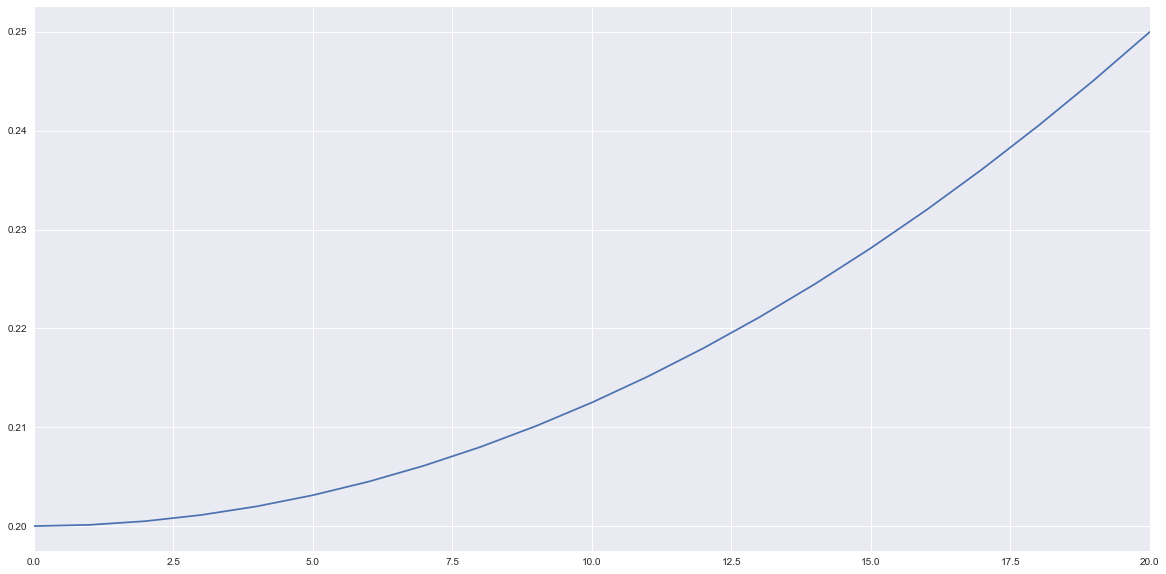

In [68]:
test_df['new_iv'].plot(figsize = (20,10))

In [22]:
test_deltas

array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, -0. ,
        0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])

C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#inde

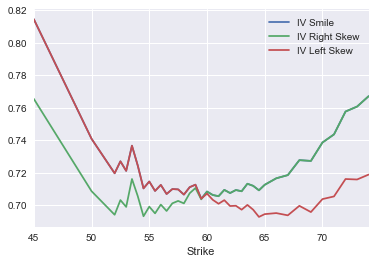

In [234]:
from scipy.stats import norm
test_chain = calls[['Strike','Expiry','DTE','Type','Bid','Ask','Underlying_Price','Mid','Calc IV']]
test_chain.index = calls['Strike']

deltas = []
for premium, strike, time_to_expiration, flag, sigma in zip(test_chain['Mid'], 
                                                            test_chain['Strike'], 
                                                            test_chain['DTE'], 
                                                            test_chain['Type'],
                                                            test_chain['Calc IV']):

    # Constants
    S = test_chain['Underlying_Price'].values[0]
    K = strike
    t = time_to_expiration/float(365)
    r = 0.005 / 100
    q = 0 / 100
    
    try:
        delta = py_vollib.black_scholes_merton.greeks.analytical.delta(flag[0], S, K, t, r, sigma, q)
        deltas.append(delta)
    except:
        delta = 0.0
        deltas.append(delta)

vol_change = 0.1
test_chain['Delta'] = deltas
test_chain['IV Adj'] = test_chain['Strike'] - S
test_chain['IV Adj'] = test_chain['Strike']/test_chain['Underlying_Price'] - 1
test_chain['IV Smile'] = abs(test_chain['IV Adj'])*vol_change + vol_change + test_chain['Calc IV']
test_chain['IV Right Skew'] = test_chain['IV Adj']*vol_change + vol_change + test_chain['Calc IV']
test_chain['IV Left Skew'] = -test_chain['IV Adj']*vol_change + vol_change + test_chain['Calc IV']
test_chain[['IV Smile','IV Right Skew', 'IV Left Skew']].plot()